In [1]:
ROBBER = "R"
POLICE = "P"
BANK = "B"
EMPTY = "*"

grid = [
    [ROBBER,EMPTY,EMPTY,EMPTY],
    [EMPTY,BANK,EMPTY,EMPTY],
    [EMPTY,EMPTY,EMPTY,EMPTY],
    [EMPTY,EMPTY,EMPTY, POLICE]
]

for row in grid:
    print(' '.join(row))

R * * *
* B * *
* * * *
* * * P


In [2]:
class State:
    
    def __init__(self, robber_pos, police_pos):
        self.robber_pos = robber_pos
        self.police_pos = police_pos
        
    def __eq__(self, other):
        return isinstance(other, State) and self.robber_pos == other.robber_pos and self.police_pos == other.police_pos
    
    def __hash__(self):
        return hash(str(self.robber_pos) + str(self.police_pos))
    
    def __str__(self):
        return f"State(robber_pos={self.robber_pos}, police_pos={self.police_pos})"

In [3]:
STAY = 0
UP = 1
DOWN = 2 
LEFT = 3
RIGHT = 4

ACTIONS = [STAY, UP, DOWN, LEFT, RIGHT]

REWARD_BANK = 1
REWARD_EMPTY = 0
REWARD_CAUGHT = -10

START_ROBBER = [0,0]
START_POLICE = [3,3]

In [4]:
start_state = State(robber_pos=START_ROBBER, police_pos=START_POLICE)

In [5]:
from copy import deepcopy

def act(state,action_robber,action_police):
    def new_actor_pos(state,state_actor_pos,action):
        p = deepcopy(state_actor_pos)
        if action == UP:
            p[0] = max(0,p[0]-1)
        elif action == DOWN:
            p[0] = min(3, p[0]+1)
        elif action == LEFT:
            p[1] = max(0, p[1]-1)
        elif action == RIGHT:
            p[1] = min(3, p[1]+1)
        elif action == STAY:
            p = p
        else:
            raise ValueError(f"Unknown action {action}")
        return p
    
    pos_robber = new_actor_pos(state,state.robber_pos,action_robber)
    pos_police = new_actor_pos(state,state.police_pos,action_police)
    
    if pos_robber == pos_police:
        reward = REWARD_CAUGHT
    elif pos_robber == [1,1]:
        reward = REWARD_BANK
    else:
        reward = REWARD_EMPTY
        
    return State(robber_pos=pos_robber, police_pos=pos_police), reward


    

In [6]:
import numpy as np
import random
random.seed(42)

N_STATES = 16*16
ITERATIONS = 10000000

eps = 0.2
LAMBDA = 0.8

q_table = dict()


In [7]:
def q(state, action_robber=None):
    
    if state not in q_table:
        q_table[state] = np.zeros(len(ACTIONS))
    if action_robber is None: 
        return q_table[state]
    
    return q_table[state][action_robber]



In [8]:
def choose_action(state, eps_in):
    pos_robber = state.robber_pos
    pos_police = state.police_pos
    if pos_police[0] == 0:
        if pos_police[1] == 0:
            action_police = random.choice([ACTIONS[2],ACTIONS[4]])
        elif pos_police[1] == 3:
            action_police = random.choice([ACTIONS[2],ACTIONS[3]])
        else:
            action_police = random.choice(ACTIONS[2:5])
    elif pos_police[0] == 3:
        if pos_police[1] == 0:
            action_police = random.choice([ACTIONS[1],ACTIONS[4]])
        elif pos_police[1] == 3:
            action_police = random.choice([ACTIONS[1],ACTIONS[3]])
        else:
            action_police = random.choice([ACTIONS[1],ACTIONS[3],ACTIONS[4]])
    elif pos_police[1] == 0:
        action_police = random.choice([ACTIONS[1],ACTIONS[2],ACTIONS[4]])
    elif pos_police[1] == 3:
        action_police = random.choice(ACTIONS[1:4])
    else: 
        action_police = random.choice(ACTIONS[1:])
        
    if random.uniform(0, 1) < eps_in:   
        if pos_robber[0] == 0:
            if pos_robber[1] == 0:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[4]])
            elif pos_robber[1] == 3:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[3]])
            else:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[3],ACTIONS[4]])
        elif pos_robber[0] == 3:
            if pos_robber[1] == 0:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[4]])
            elif pos_robber[1] == 3:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[3]])
            else:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[3],ACTIONS[4]])
        elif pos_robber[1] == 0:
            action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[2],ACTIONS[4]])
        elif pos_robber[1] == 3:
            action_robber = random.choice(ACTIONS[0:4])
        else: 
            action_robber = random.choice(ACTIONS)
    else:
        action_robber = np.argmax(q(state))
    
    return action_robber, action_police


In [9]:
index_matrix = np.arange(16).reshape((4,4))
state_index_matrix = np.arange(16*16).reshape((16,16))
policy_matrix = np.zeros((16,16))+10 # 10, to make sure an action is choosen in all states

def state_matrix(state):
    pos_police = state.police_pos
    pos_robber = state.robber_pos
    # police along rows, robber along columns
    col_r = index_matrix[pos_robber[0]][pos_robber[1]]
    row_p = index_matrix[pos_police[0]][pos_police[1]]
    state_index = state_index_matrix[row_p][col_r]
    
    best_move = np.argmax(q(state))
    policy_matrix[row_p][col_r] = best_move
    
    return(state_index)

In [10]:
# SARSA Algorithm

state = start_state
action_robber, action_police = choose_action(start_state, eps)
total_reward = 0

# Choose another intersting state to plot
other_state = State(robber_pos=[1,1], police_pos=[2,1])
# What state to plot
plot_state = start_state
plot_string = "Value in start state"

values = []
times = []
rewards = []

n_updates_Q = np.zeros((len(ACTIONS),16*16))

for t in range(ITERATIONS):
    new_eps = eps#eps**(1+t*(10**(-7)))
    next_state, reward = act(state, action_robber, action_police)
    next_action_robber, next_action_police = choose_action(next_state, new_eps)
    
    total_reward += reward

    state_index = state_matrix(state)
    n_updates_Q[action_robber][state_index] += 1
    
    alpha = 1/(n_updates_Q[action_robber][state_index]**(2/3))
    
    q(state)[action_robber] = q(state, action_robber) + \
            alpha * (reward + LAMBDA *q(next_state,next_action_robber) - q(state, action_robber))

    state = next_state
    action_robber = next_action_robber
    action_police = next_action_police
    
    if t%10000==0:
        # Look at the first state or other state taking the action with max q value
        values.append(max(q(plot_state)))
        times.append(t)
        rewards.append(total_reward)
        #print(max(q(start_state)))
        #print(t)



print(n_updates_Q)

0.0
0
1.3384452307566532
10000
1.4583725460760146
20000
1.6659815810678076
30000
1.5103920270575244
40000
1.5557117904088997
50000
1.4439312292705397
60000
1.35917888336562
70000
1.4064971262735952
80000
1.3761819595660338
90000
1.5227422868794995
100000
1.65067066770542
110000
1.7596974496632836
120000
1.7596974496632836
130000
1.8416893994235028
140000
1.9859903815063393
150000
1.9859903815063393
160000
2.051815014437958
170000
2.061374692632251
180000
1.9483714734965865
190000
2.0077113206842343
200000
2.0077113206842343
210000
1.962452353667158
220000
1.962452353667158
230000
1.962452353667158
240000
2.0175294207955754
250000
2.215471240970096
260000
2.253714460857921
270000
2.290026565963057
280000
2.3247562363814107
290000
2.378136117191172
300000
2.399953717477892
310000
2.4455182329828324
320000
2.4455182329828324
330000
2.4455182329828324
340000
2.4670697650530253
350000
2.4670697650530253
360000
2.4830389485241406
370000
2.4983920881899486
380000
2.4654909038714883
390000
2.4

2.6074610321253884
3140000
2.6074610321253884
3150000
2.6136530198739196
3160000
2.6174184550292585
3170000
2.6174184550292585
3180000
2.6174184550292585
3190000
2.620660756421522
3200000
2.62369221044244
3210000
2.62486672518094
3220000
2.6031726375422943
3230000
2.6031726375422943
3240000
2.6053431136778467
3250000
2.607408432982666
3260000
2.6155620511770437
3270000
2.6175260669482148
3280000
2.6213321102355165
3290000
2.6065507124060963
3300000
2.6086868431043344
3310000
2.610790181405612
3320000
2.6129536065378076
3330000
2.618670058157031
3340000
2.618670058157031
3350000
2.597497535026603
3360000
2.5999279912018527
3370000
2.5999279912018527
3380000
2.5843471877176833
3390000
2.591305635544951
3400000
2.6051016486701792
3410000
2.6051016486701792
3420000
2.611347123149678
3430000
2.6233662051269815
3440000
2.575548925393952
3450000
2.575548925393952
3460000
2.5783850765466854
3470000
2.5783850765466854
3480000
2.583492306812627
3490000
2.583492306812627
3500000
2.594669943819104

2.5849398303692044
6220000
2.5849398303692044
6230000
2.586548235200473
6240000
2.588108478001489
6250000
2.5683771422150166
6260000
2.5683771422150166
6270000
2.5683771422150166
6280000
2.555822240659444
6290000
2.555822240659444
6300000
2.5594534354560734
6310000
2.5594534354560734
6320000
2.5629156965496356
6330000
2.5664045741845602
6340000
2.568062611251854
6350000
2.5697216453949476
6360000
2.5728682204153053
6370000
2.577794281541828
6380000
2.5823649367453325
6390000
2.5837394902695747
6400000
2.588002845240446
6410000
2.589346332047015
6420000
2.5963170608514305
6430000
2.5963170608514305
6440000
2.5963170608514305
6450000
2.5978541972684703
6460000
2.600182693855299
6470000
2.5942587587653643
6480000
2.5985654682293027
6490000
2.592603564362041
6500000
2.592603564362041
6510000
2.5849099432405382
6520000
2.587874857647179
6530000
2.587874857647179
6540000
2.5835671038927113
6550000
2.582098228949763
6560000
2.5790418022441006
6570000
2.582036898788753
6580000
2.58333165368822

2.577775283853942
9340000
2.5801093358228053
9350000
2.581272820478244
9360000
2.581272820478244
9370000
2.584835410545993
9380000
2.584835410545993
9390000
2.587077433506722
9400000
2.57834784235212
9410000
2.5829481822114455
9420000
2.5829481822114455
9430000
2.5851841028343965
9440000
2.5771662310436514
9450000
2.578304677343231
9460000
2.5805809005838865
9470000
2.581756107114925
9480000
2.581756107114925
9490000
2.58411260502445
9500000
2.5852482323591848
9510000
2.5815621556318273
9520000
2.57485511419622
9530000
2.579743292482699
9540000
2.5832855742840866
9550000
2.5845411229647284
9560000
2.58685303571092
9570000
2.5901972245481373
9580000
2.5901972245481373
9590000
2.585558980657036
9600000
2.5785459380468105
9610000
2.5810957207897376
9620000
2.5711836525659386
9630000
2.5711836525659386
9640000
2.5711836525659386
9650000
2.5724544697044402
9660000
2.5750169742648263
9670000
2.5657847539521588
9680000
2.5626741468677707
9690000
2.563968222770716
9700000
2.563968222770716
971

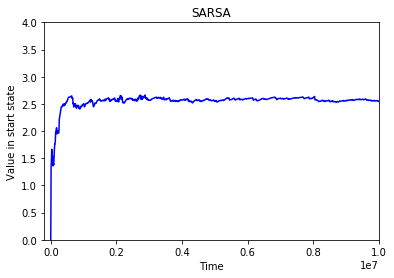

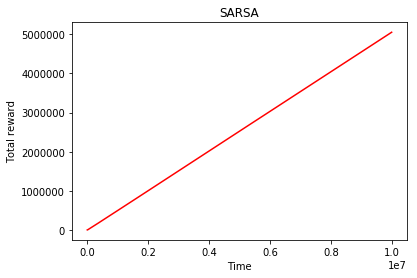

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(times,values,'b')
plt.title("SARSA")
plt.xlabel("Time")
plt.ylabel(plot_string)
plt.xlim(-200000, 10000000)
plt.ylim(0, 4.0)
plt.show()

plt.plot(times,rewards,'r')
plt.title("SARSA")
plt.xlabel("Time")
plt.ylabel("Total reward")
plt.show()

In [12]:
print(len(q_table))

256


In [13]:
def get_spec_policy(grid_index_police):
    print(policy_matrix)
    fixed_police = policy_matrix[grid_index_police]
    fixed_police_policy = fixed_police.reshape(4,4)
    police_idx = np.where(index_matrix==grid_index_police)
    fixed_police_policy[police_idx[0][0]][police_idx[1][0]] = 9
    print(fixed_police_policy)
get_spec_policy(5)

[[0. 2. 2. 2. 4. 0. 3. 0. 0. 1. 0. 1. 4. 0. 1. 1.]
 [2. 0. 2. 2. 0. 2. 0. 3. 4. 0. 3. 0. 4. 1. 0. 3.]
 [2. 2. 0. 3. 4. 0. 3. 0. 0. 1. 0. 3. 1. 1. 3. 3.]
 [2. 2. 3. 0. 4. 0. 3. 3. 1. 1. 3. 0. 1. 1. 3. 3.]
 [4. 0. 2. 0. 0. 4. 0. 3. 4. 0. 1. 3. 0. 1. 1. 1.]
 [0. 2. 0. 3. 4. 0. 3. 0. 0. 1. 0. 3. 4. 0. 1. 0.]
 [2. 0. 3. 0. 0. 3. 0. 3. 1. 0. 3. 0. 1. 1. 0. 3.]
 [2. 2. 3. 3. 4. 0. 3. 0. 1. 1. 3. 3. 1. 1. 3. 2.]
 [4. 2. 0. 3. 4. 0. 3. 3. 0. 1. 1. 1. 1. 0. 1. 3.]
 [4. 0. 3. 2. 0. 1. 0. 3. 1. 0. 1. 1. 0. 1. 0. 1.]
 [4. 2. 3. 3. 4. 0. 3. 0. 1. 1. 0. 1. 1. 0. 1. 0.]
 [2. 2. 3. 3. 4. 0. 3. 3. 1. 1. 3. 0. 1. 1. 3. 3.]
 [4. 2. 3. 3. 4. 0. 3. 3. 1. 1. 1. 1. 0. 1. 0. 1.]
 [4. 2. 3. 3. 4. 0. 3. 3. 1. 1. 1. 1. 1. 0. 1. 0.]
 [2. 2. 3. 3. 4. 0. 3. 3. 1. 1. 1. 1. 1. 1. 0. 1.]
 [2. 2. 3. 3. 4. 0. 3. 3. 1. 1. 3. 1. 1. 1. 3. 2.]]
[[0. 2. 0. 3.]
 [4. 9. 3. 0.]
 [0. 1. 0. 3.]
 [4. 0. 1. 0.]]
